In [29]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image
import os
%env SCIPY_ARRAY_API=1
from sklearn.linear_model import Ridge
import cupy
import naplib as nl
from naplib.visualization import strf_plot
import thesis
import yaml

env: SCIPY_ARRAY_API=1


In [30]:
# thesis.utils.convert_to_npy("response")

In [31]:
raw_response = thesis.load_data.load_response()
raw_stimulus = thesis.load_data.load_stimulus()
height, width = int(raw_response.shape[2]), int(raw_response.shape[3])

[0.0000e+00 4.0000e-06 8.0000e-06 ... 4.9988e-02 4.9992e-02 4.9996e-02]


In [32]:
from math import gcd

code_params = {
    "block_size": gcd(width, height),
    "strf_fit_dtype": np.float64,
    "strf_fit_batch_size": 10,
    "sr_audio": 250000,
    "sr_response": 100,
    "max_lag": 0.05,
    "end_stim": 37500 / 250000,
    "max_epochs": 150,
    'reduce_data': False
}

code_params["block_size"] = (10, 10)
code_params["strf_fit_dtype"] = np.float16

In [33]:
# # make movie
# frame_size = test_data.shape[1:3]

# out_lossless = cv2.VideoWriter('test_video.mkv',cv2.VideoWriter_fourcc(*'FFV1'), 100, (frame_size[1], frame_size[0]))
# out_lossy = cv2.VideoWriter('test_video_lossy.mkv',cv2.VideoWriter_fourcc(*'VP90'), 100, (frame_size[1], frame_size[0]))

# cm_test_data = np.copy(test_data)

# bwr_cm = cm.get_cmap('bwr')
# cm_test_data = bwr_cm((test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data)))

# cm_test_data = (cm_test_data[:, :, :, :3]*255).astype(np.uint8)

# example_images = 100, 250, 400

# for index, frame in enumerate(cm_test_data):
#     if index in example_images:
#         cv2.imwrite(f"images/frame_{index}.png", frame)
#     out_lossless.write(frame)
#     out_lossy.write(frame)
# out_lossless.release()
# out_lossy.release()

In [34]:
delay = int(code_params["sr_response"] * code_params["max_lag"])
stimulus = raw_stimulus[:, : int(code_params["end_stim"] * code_params["sr_audio"])]
response = raw_response[
    :,
    200
    + delay : 200
    + int(code_params["end_stim"] * code_params["sr_response"] + delay),
    :,
    :,
]
print(response.shape)
if code_params['reduce_data']:
    small_response = thesis.preprocessing.smallify_response(
    response, code_params["block_size"]
)
else: 
    small_response = response

print(small_response.shape)
    
small_height, small_width = small_response.shape[2], small_response.shape[3]
small_response = small_response.reshape(
    small_response.shape[0], small_response.shape[1], -1
)
thesis.thesis_logger.logger.debug(f"Frame dimensions are {small_height}, {small_width}.")


(50, 15, 170, 152)
(50, 15, 170, 152)


Frame dimensions are 170, 152.


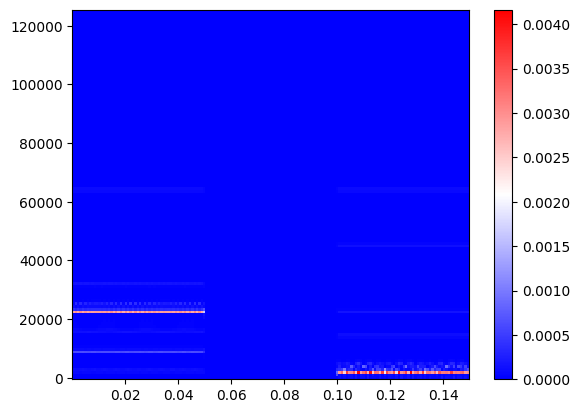

In [35]:
import scipy as sp
from sklearn.preprocessing import StandardScaler

# clip response to stimulus start and normalize
# = MinMaxScaler()
f, t, Sxx = sp.signal.spectrogram(np.sum(stimulus, axis=0), fs=code_params["sr_audio"])
plt.pcolormesh(t, f, Sxx, cmap="bwr")
plt.colorbar()
plt.show()

In [36]:
spec = thesis.generate.generate_spectrogram(
    stimulus, response, sr_audio=code_params["sr_audio"]
)

In [41]:
### data naming

code_params["output_prefix"] = f"output/{desc_param}"
code_params["crossval"] = False
code_params["jackknife"] = False
res = f"{small_height}x{small_width}"
desc_param = ("jack" if code_params['jackknife'] else "") + ("CV" if code_params["crossval"] else "") + ("reduced" if code_params["reduce_data"] else "") + res

with open('prep_response.npy', 'wb') as f:
    np.save(f, small_response)
with open('prep_spec.npy', 'wb') as f:
    np.save(f, spec)

with open("code_params.yaml", "w") as file:
    yaml.dump(code_params, file)